<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" width="120px" />


# Clasificación de dígitos con redes convolucionales<a id="top"></a>

<i><small>Última actualización: 2025-03-1</small></i></div>
***

## Introducción

En este _notebook_ vamos a crear un clasificador para el problema del **CIFAR-100** usando para ello un modelo de red neuronal convolucional (CNN, del inglés _convolutional neural network_).

Las CNN son un tipo de red neuronal que, aunque mantiene un comportamiento _feed-forward_, aprovecha la estructura de los datos de entrada (normalmente imágenes, pero en general cualquier conjunto de datos con relaciones espaciales) para reducir el tamaño del modelo y mejorar su rendimiento.

¿Por qué es esto? Pues por varias razones, aunque las principales son las siguientes:

### 1. Los MLP no escalan bien con imágenes grandes.

Imaginemos una imagen a color de $32 \times 32$ píxeles, como las de **CIFAR-100**. Si usáramos una red neuronal densa para clasificarla, necesitaríamos una capa de entrada con $32 \times 32 \times 3 = 3072$ neuronas. Si esta primera capa tuviera solo $256$ neuronas ocultas, el número total de pesos a entrenar sería:

$$
3072 \times 256 + 256 = 786688
$$

A $32$ bits por pesos, esto ocuparía aproximadamente **3MiB** de memoria solo para la primera capa. Si trabajaramos con imágenes de tamaño mediano, como las del [conjunto _ImageNet_](https://www.image-net.org/) (que son de $224 \times 224$ píxeles), este número superaría los **38 millones de pesos**, consumiendo unos $147$ MiB. Esto es claramente inviable a gran escala.

En cambio, una CNN usa muchas menos conexiones. Por ejemplo, si en la primera capa aplicamos 32 filtros de $3 \times 3$ sobre la misma imagen, el número de pesos sería:

$$
32 \times 3 \times 3 \times 3 + 32 = 896
$$

Esto ocuparía apenas $3.5$ KiB, independientemente del tamaño de la imagern, ya que los pesos pertenecen a los filtros, no a los píxeles individuales.

### 2. Los MLP no aprovechan la estructura de los datos

Las imágenes tienen una estructura espacial que los MLP. Por ejemplo, si un MLP ve una imagen de un gato y luego la misma imagen desplazada unos píxeles, no tiene por qué reconocerla como el mismo gato. Esto se denomina **invariancia a la traslación**, y los MLP no la poseen.

Las CNN, en cambio, están diseñadas para captar la estructura espacial de los datos. Cada filtro de una capa de convolución aprende a detectar patrones que pueden aparecer en cualquier parte de la entrada. Esto les permite identificar características sin importar su posición exacta, lo que las hace ideales para tareas de visión por ordenador.

## Objetivos

Nuestro objetivo será implementar una CNN y compararla con el MLP que desarrollamos anteriormente, para analizar las diferencias entre ambos modelos.

## Bibliotecas y configuración

A continuación, importaremos las bibliotecas necesarias para el desarrollo de este notebook.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchmetrics
import torchvision

import utils

También configuraremos algunos parámetros para optimizar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Por último, definiremos las constantes que utilizaremos como recursos comunes.

In [3]:
DATASETS_DIR = './tmp'
TRAIN_EPOCHS = 100

***

## Preparación de los datos.

Antes de entrenar nuestro modelo, veamos en detalle los datos con los que vamos a trabajar. El [conjunto de datos **CIFAR-100**](https://www.cs.toronto.edu/~kriz/cifar.html) contiene $60000$ imágenes a color de $32 \times 32$ píxeles, divididas en $100$ clases, con $600$ imágenes por clase. A diferencia de su versión más conocida (**CIFAR-10**), que solo tiene $10$ categorías generales (avión, coche, pájaro, etc.), CIFAR-100 es más desafiante, ya que cada clase representa un objeto o animal específico. El conjunto de datos está distribuido en $50000$ imágenes para entrenamiento y $10000$ para pruebas.

![](images/CIFAR-100.png)

Cada clase pertenece, además, a una categoría superior (por ejemplo, «_maple tree_» pertenece a «_trees_»). Esto nos permite agruparlas y usarlas en modelos más avanzados. En PyTorch, podemos cargar este conjunto de datos fácilmente desde `torchvision.datasets.CIFAR100`, que nos permite descargarlo y preprocesarlo sin complicaciones.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Estandarizamos utilizando la fórmula del z-score. Para ello, usamos las
    #  medias y desviaciones típicas para cada canal de color del CIFAR-100.
    torchvision.transforms.Normalize(
        mean=[0.5071, 0.4865, 0.4409],
        std=[0.2673, 0.2564, 0.2761],
    )
])

train_dataset = torchvision.datasets.CIFAR100(
    root=DATASETS_DIR,
    train=True,
    download=True,
    transform=transform,
)
test_dataset = torchvision.datasets.CIFAR100(
    root=DATASETS_DIR,
    train=False,
    download=False,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    num_workers=2,  # Dos workers => Dos hilos cargando datos en lugar de uno
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
)

Vemos que el conjunto de datos se divide en un conjunto de datos de entrenamiento de 60000 ejemplos y un conjunto de test de 10000 ejemplos. El primero es con el que entrenaremos nuestro modelo mientras que el segundo servirá para evaluar el desempeño del modelo con datos que no ha visto nunca.

Veamos la forma que tienen los datos de entrada de un ejemplo en concreto (al estar estandarizados, la imagen no es real porque los valores han sido estandarizados):

In [ ]:
INDEX = 42

image, label = train_dataset[INDEX]
image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

plt.imshow(image)
plt.axis("off")
plt.title(f"Index: {INDEX}, label: {label}, shape: {image.shape}")
plt.show()

## Creación del modelo

Vamos a construir una CNN sencilla, sin estructuras complejas ni ramificaciones. Dado que las capas se aplicarán en **orden secuencial**, podemos definir el modelo utilizando la API `Sequential` de PyTorch, que nos permite encadenar capas de forma directa.

En PyTorch, `torch.nn.Sequential` se comporta como una **lista de capas** que se ejecutan en el orden en que se añaden. Existen dos formas de definir un modelo secuencial:

1. Pasando las capas como una lista al constructor de `torch.nn.Sequential`, y
2. Añadiendo capas una a una (aunque en PyTorch esto no se hace con `add`, como en Keras).

A continuación, crearemos nuestra CNN para CIFAR-100 usando `torch.nn.Sequential`.

In [6]:
model_cnn = torch.nn.Sequential()

Ahora añadiremos una capa oculta. Si nos acordamos de teoría, las CNN se componen de dos partes, la parte de extracción de características, compuesta de capas de convolución, y las capas de inferencia, compuestas de capas densas. Comenzaremos con una capa de convolución:

In [7]:
model_cnn.add_module(
    "conv1",
    torch.nn.Conv2d(  # (batch, channels, height, width)
        in_channels=3,
        out_channels=8,
        kernel_size=3,
        padding="same",
    )
)

Acabamos de crear una capa compuesta de 8 convoluciones de tamaño $3 \times 3 \times 3$ que navegará por toda la imagen extrayendo características.

Después de la capa de convolución, es importante añadir la función de activación. Usaremos una tipo _leaky_ ReLU con una pendiente negativa de $0.1$.

In [8]:
model_cnn.add_module("acti1", torch.nn.LeakyReLU(negative_slope=0.1))

Otra capa que se suele combinar con las de convolución son las de muestreo parcial, _subsampling_ o _pooling_. Si recordamos, se trataba de filtros que reducían la imágen sacando los valores más destacables de cada área que cubre el filtro. En este caso, usaremos una capa `torch.nn.MaxPool2D` que escogerá el valor más alto del área que cubre. El valor por defecto del parámetro opcional `stride` (el salto del filtro) es el del tamaño del filtro, así que definiremos el filtro como $2 \times 2$ y dejaremos que el _stride_ quede así para que no haya solapamiento. Esto reducirá bastante el tamaño de la salida de la capa anterior.

In [9]:
model_cnn.add_module("pool1", torch.nn.MaxPool2d(kernel_size=2))

De momento vamos a mantener una única capa de convolución, una función de activación y una de _pooling_, vamos a saltar a la parte de inferencia.

Ahora bien, para saltar a la parte de inferencia (que no deja de ser un MLP) necesitamos que todos los datos de entrada estén en una dimensión. Por ello, antes de entrar en la capa de inferencia, vamos a «aplanar» la salida de la convolución.

In [10]:
model_cnn.add_module("flatten", torch.nn.Flatten())

No necesitamos parámetros, lo único que hace es poner la matriz multidimensional en dos dimensiones, el número de ejemplos y todas las características extraídas para dicho ejemplo.

Ahora vamos a añadir las capas densas que queramos. Vamos a añadir una oculta primero.

In [11]:
model_cnn.add_module(
    "fc1", torch.nn.Linear(in_features=8 * 16 * 16, out_features=128)
)
model_cnn.add_module("relu2", torch.nn.ReLU())

Y la de salida. Recordemos, la salida serán **100 neuronas**, una por cada posible clase.

In [12]:
model_cnn.add_module("fc2", torch.nn.Linear(in_features=128, out_features=100))

Ya explicamos previamente por qué no explicitamos la función _softmax_ o _log-softmax_. Por tanto ya tenemos definido nuestro modelo. Veamos su estructura.

In [13]:
print(model_cnn)
total_params = sum(p.numel() for p in model_cnn.parameters())
print(f"No. of parameters: {total_params}")

Sequential(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (acti1): LeakyReLU(negative_slope=0.1)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=128, out_features=100, bias=True)
)
No. of parameters: 275396


Vamos a compararlo con un perceptrón multicapa de un par de capas ocultas con aproximadamente el mismo número de parámetros.

In [14]:
model_mlp = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=3 * 32 * 32, out_features=85),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.Linear(in_features=85, out_features=75),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.Linear(in_features=75, out_features=100)
)
print(model_mlp)
total_params = sum(p.numel() for p in model_mlp.parameters())
print(f"No. of parameters: {total_params}")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=85, bias=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Linear(in_features=85, out_features=75, bias=True)
  (4): LeakyReLU(negative_slope=0.1)
  (5): Linear(in_features=75, out_features=100, bias=True)
)
No. of parameters: 275255


Ahora veamos qué tal se comportan en un par de entrenamientos. Para ello los entrenaremos con los mismos algoritmos y el mismo número de epochs. Usaremos la función `train` definida en el módulo `utils.py` porque es un código muy repetitivo.

In [15]:
history_cnn = utils.train(
    model=model_cnn,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_cnn.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

Epoch 1/100 (11.63s), Train loss: 3.8824, Train metric: 0.1207, Val loss: 3.5331, Val. metric: 0.1744
Epoch 2/100 (12.81s), Train loss: 3.3179, Train metric: 0.2135, Val loss: 3.2289, Val. metric: 0.2264
Epoch 3/100 (12.87s), Train loss: 3.0198, Train metric: 0.2689, Val loss: 3.0562, Val. metric: 0.2554
Epoch 4/100 (14.16s), Train loss: 2.8255, Train metric: 0.3034, Val loss: 2.9721, Val. metric: 0.2721
Epoch 5/100 (11.92s), Train loss: 2.6919, Train metric: 0.3343, Val loss: 2.9294, Val. metric: 0.2849
Epoch 6/100 (12.48s), Train loss: 2.5894, Train metric: 0.3508, Val loss: 2.9153, Val. metric: 0.2938
Epoch 7/100 (10.94s), Train loss: 2.5070, Train metric: 0.3711, Val loss: 2.9061, Val. metric: 0.2983
Epoch 8/100 (11.55s), Train loss: 2.4349, Train metric: 0.3860, Val loss: 2.8556, Val. metric: 0.3058
Epoch 9/100 (11.82s), Train loss: 2.3648, Train metric: 0.3989, Val loss: 2.8937, Val. metric: 0.3042
Epoch 10/100 (11.37s), Train loss: 2.3052, Train metric: 0.4130, Val loss: 2.8888,

Veamos la evolución de su error y su exactitud:

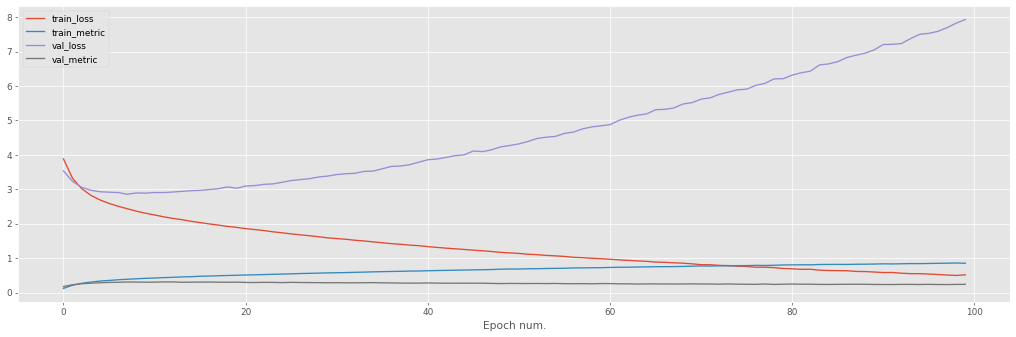

In [16]:
pd.DataFrame(history_cnn).plot()
plt.xlabel('Epoch num.')
plt.show()

Ahora haremos lo mismo con el MLP.

In [17]:
history_mlp = utils.train(
    model=model_mlp,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_mlp.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

Epoch 1/100 (9.44s), Train loss: 3.9208, Train metric: 0.1120, Val loss: 3.6391, Val. metric: 0.1513
Epoch 2/100 (11.67s), Train loss: 3.5131, Train metric: 0.1770, Val loss: 3.5029, Val. metric: 0.1804
Epoch 3/100 (10.14s), Train loss: 3.3547, Train metric: 0.2032, Val loss: 3.4127, Val. metric: 0.1956
Epoch 4/100 (8.60s), Train loss: 3.2370, Train metric: 0.2260, Val loss: 3.3791, Val. metric: 0.2024
Epoch 5/100 (8.31s), Train loss: 3.1486, Train metric: 0.2418, Val loss: 3.3142, Val. metric: 0.2192
Epoch 6/100 (8.23s), Train loss: 3.0743, Train metric: 0.2568, Val loss: 3.3241, Val. metric: 0.2105
Epoch 7/100 (8.98s), Train loss: 3.0104, Train metric: 0.2659, Val loss: 3.3340, Val. metric: 0.2092
Epoch 8/100 (8.14s), Train loss: 2.9523, Train metric: 0.2793, Val loss: 3.3155, Val. metric: 0.2153
Epoch 9/100 (8.20s), Train loss: 2.8989, Train metric: 0.2895, Val loss: 3.3113, Val. metric: 0.2193
Epoch 10/100 (8.49s), Train loss: 2.8523, Train metric: 0.2975, Val loss: 3.3233, Val. me

Y veamos también la evolución de su error y su exactitud.

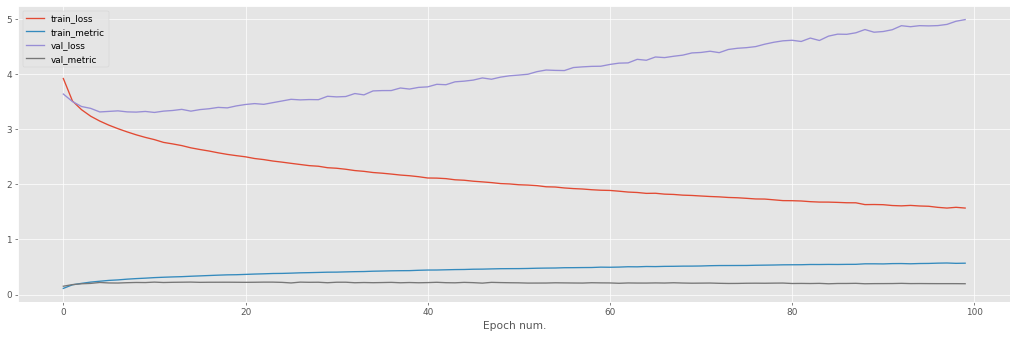

In [18]:
pd.DataFrame(history_mlp).plot()
plt.xlabel('Epoch num.')
plt.show()

Parece que, aunque el MLP funciona bastante bien, la red no es capaz de llegar a tanta precisión como la CNN. Tiene sentido, ya que muchos de los parámetros se ocupan de relacionar píxeles que probablemente tengan muy poco que ver. Veamos qué tal se comportan con el conjunto de test. Al igual que con el entrenamiento, usaremos la función `evaluate` del módulo `utils` para no repetirnos demasiado.

In [19]:
eval_cnn = utils.evaluate(
    model=model_cnn,
    data_loader=test_loader,
    criterion=torch.nn.CrossEntropyLoss(),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)
eval_mlp = utils.evaluate(
    model=model_mlp,
    data_loader=test_loader,
    criterion=torch.nn.CrossEntropyLoss(),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)
print(f'Results for CNN: Loss: {eval_cnn.get("loss")}, Acc: {eval_cnn.get("metric")}')
print(f'Results for MLP: Loss: {eval_mlp.get("loss")}, Acc: {eval_mlp.get("metric")}')

Results for CNN: Loss: 8.15807254486084, Acc: 0.2185489982366562
Results for MLP: Loss: 5.059770454406738, Acc: 0.18401937186717987


Además hemos hecho una pequeña trampa. Nuestra red de convolución sólo tiene una capa, y esto provoca que el resultado sea muy grande. Este, al conectarlo con la capa densa hace que el número de parámetros crezca dramáticamente.

Vamos a tratar de solucionar esto y a comparar con un nuevo perceptrón.

In [20]:
model_cnn_2 = torch.nn.Sequential(
    # Primera capa convolucional
    torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding="same"),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.MaxPool2d(kernel_size=2),
    # Segunda capa convolucional
    torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same"),
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.MaxPool2d(kernel_size=2),
    # Aplanamiento de las salidas
    torch.nn.Flatten(),
    # Inferencia
    torch.nn.Linear(16 * 8 * 8, 8),  # La entrada es 8*8*8 después del último MaxPool
    torch.nn.LeakyReLU(negative_slope=0.1),
    torch.nn.Linear(8, 100),  # 100 clases en CIFAR-100
)

print(model_cnn_2)
total_params = sum(p.numel() for p in model_cnn_2.parameters())
print(f"No. of parameters: {total_params}")

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.1)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.1)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=8, bias=True)
  (8): LeakyReLU(negative_slope=0.1)
  (9): Linear(in_features=8, out_features=100, bias=True)
)
No. of parameters: 10492


Hemos pasado de un plumazo de $275396$ a $10492$. ¡Casi nada!. Vamos su desempeño.

In [21]:
history_cnn_2 = utils.train(
    model=model_cnn_2,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model_cnn_2.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

Epoch 1/100 (11.49s), Train loss: 4.4615, Train metric: 0.0294, Val loss: 4.2715, Val. metric: 0.0496
Epoch 2/100 (12.05s), Train loss: 4.1273, Train metric: 0.0662, Val loss: 3.9909, Val. metric: 0.0849
Epoch 3/100 (11.06s), Train loss: 3.9084, Train metric: 0.0922, Val loss: 3.8271, Val. metric: 0.1066
Epoch 4/100 (11.14s), Train loss: 3.7670, Train metric: 0.1100, Val loss: 3.7141, Val. metric: 0.1213
Epoch 5/100 (12.49s), Train loss: 3.6627, Train metric: 0.1245, Val loss: 3.6375, Val. metric: 0.1294
Epoch 6/100 (11.95s), Train loss: 3.5850, Train metric: 0.1381, Val loss: 3.5832, Val. metric: 0.1382
Epoch 7/100 (12.22s), Train loss: 3.5212, Train metric: 0.1462, Val loss: 3.5398, Val. metric: 0.1527
Epoch 8/100 (11.48s), Train loss: 3.4640, Train metric: 0.1573, Val loss: 3.4840, Val. metric: 0.1606
Epoch 9/100 (11.02s), Train loss: 3.4172, Train metric: 0.1640, Val loss: 3.4508, Val. metric: 0.1594
Epoch 10/100 (11.34s), Train loss: 3.3685, Train metric: 0.1724, Val loss: 3.4073,

Gráficamente, la evolución queda como sigue:

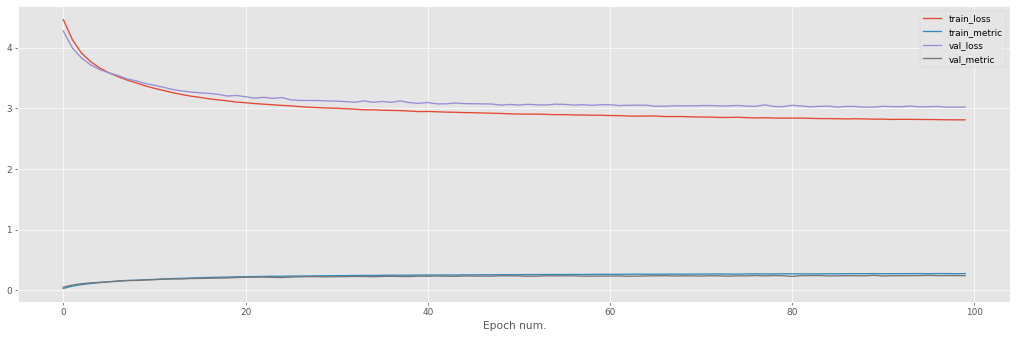

In [22]:
pd.DataFrame(history_cnn_2).plot()
plt.xlabel('Epoch num.')
plt.show()

Parece un entrenamiento más estable y con mejores valores. Comparemos ahora los resultados de los tres modelos con el conjunto de test.

In [23]:
eval_cnn_2 = utils.evaluate(
    model=model_cnn_2,
    data_loader=test_loader,
    criterion=torch.nn.CrossEntropyLoss(),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

print(f'Results for CNN 2.0: Loss: {eval_cnn.get("loss")}, Acc: {eval_cnn.get("metric")}')
print(f'Results for CNN:     Loss: {eval_cnn_2.get("loss")}, Acc: {eval_cnn_2.get("metric")}')
print(f'Results for MLP:     Loss: {eval_mlp.get("loss")}, Acc: {eval_mlp.get("metric")}')

Results for CNN 2.0: Loss: 8.15807254486084, Acc: 0.2185489982366562
Results for CNN:     Loss: 3.0239676986694337, Acc: 0.22723986208438873
Results for MLP:     Loss: 5.059770454406738, Acc: 0.18401937186717987


El modelo generaliza mejor que el resto y además ocupa muchísimo menos. Parece que la arquitectura de CNN se comporta bastante mejor para este tipo de problemas.

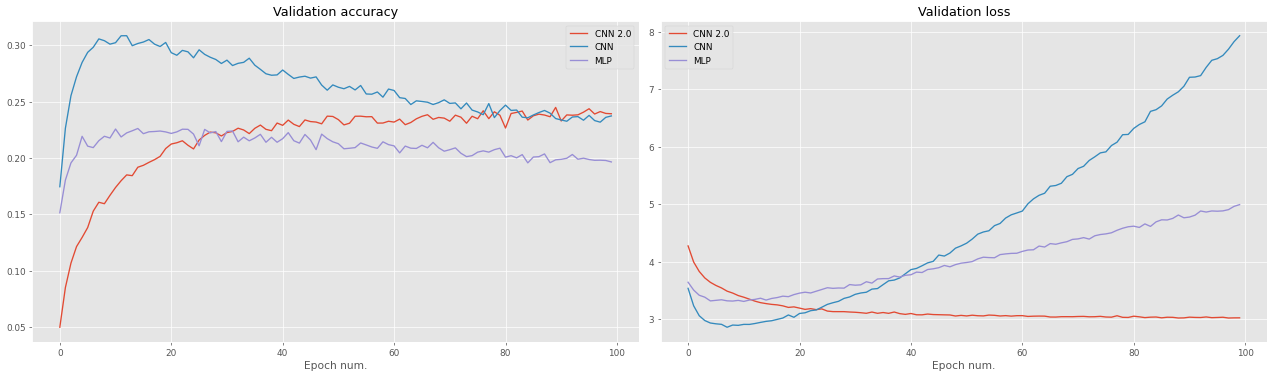

In [24]:
fig, axs = plt.subplots(1, 2)

pd.DataFrame({
    "CNN 2.0": history_cnn_2['val_metric'],
    "CNN": history_cnn['val_metric'],
    "MLP": history_mlp['val_metric'],
}).plot(ax=axs[0])
axs[0].set_xlabel('Epoch num.')
axs[0].set_title('Validation accuracy')

pd.DataFrame({
    "CNN 2.0": history_cnn_2['val_loss'],
    "CNN": history_cnn['val_loss'],
    "MLP": history_mlp['val_loss'],
}).plot(ax=axs[1])
axs[1].set_xlabel('Epoch num.')
axs[1].set_title('Validation loss')

plt.tight_layout()
plt.show()

Sin embargo, tiene un problema que es probable que hayamos identificado: La velocidad de entrenamiento. Después de todo, las operaciones de convolución son más lentas que un simple producto de matrices.

## Modelos LeNet y AlexNet

El modelo de red convolucional LeNet es una de las primeras redes neuronales que usaron opreaciones de convolución. Fue propuesta por Yann LeCun [1] en 1989 para el problema del reconocimiento (i.e. clasificación) de números manuscritos

LeNet es el modelo en el que se inspira AlexNet [2], el modelo de que ganó la competición ImageNet en 2012 y que se considera como el origen de la vorágine del deep learning que nos ha traído hasta el momento actual.

<figure>
    <center>
        <img src="https://media.licdn.com/dms/image/D4E12AQFOevexWWMwhA/article-cover_image-shrink_600_2000/0/1680257599468?e=2147483647&v=beta&t=AaLo1l9ln5Tyl1ArH1sRlKELkjFdTrpRf_My-uaHuf4" alt="Lenet vs AlexNet" style="width:70%" />
        <figcaption align = "center"><strong>Figura 1</strong>. Diferencias entre arquitecturas LeNet y AlexNet. Fuente: <a href="https://www.linkedin.com/pulse/lenet-alexnet-chandrahasa-sreeramaneni">LinkedIn</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=104937230">Link</a></figcaption>
    </center>
</figure>

Fijémonos en el año del primero. Usaron los algoritmos de retropropagación recién propuestos (1986, aunque es cierto que la técnica tiene predecesores) para el entrenamiento de los filtros de convolución. Por ello, sus autores se consideran pioneros en la clasificación de imágenes.

Crearemos ahora estas arquitecturas para ver cómo se comportan con este conjunto de datos.

### Arquitectura LeNet

Existen muchas variantes diferentes. Nosotros implementaremos la mostrada en la Figura 1, pero no es la original (partiendo de que esta además toma como entrada imágenes de $32 \times 32$.

In [25]:
lenet = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding='same'),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=16 * 6 * 6, out_features=120),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(p=0.75),
    torch.nn.Linear(in_features=120, out_features=84),
    torch.nn.Sigmoid(),
    torch.nn.Dropout(p=0.75),
    torch.nn.Linear(in_features=84, out_features=100),
)

print(lenet)
total_params = sum(p.numel() for p in lenet.parameters())
print(f"No. of parameters: {total_params}")

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=576, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Dropout(p=0.75, inplace=False)
  (10): Linear(in_features=120, out_features=84, bias=True)
  (11): Sigmoid()
  (12): Dropout(p=0.75, inplace=False)
  (13): Linear(in_features=84, out_features=100, bias=True)
)
No. of parameters: 90776


Esta arquitectura bastantes más parámetros que las última red. Veamos cómo progresa el entrenamiento durante 50 epochs como en los anteriores ejemplos.

In [26]:
history_lenet = utils.train(
    model=lenet,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(lenet.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

Epoch 1/100 (10.72s), Train loss: 4.6431, Train metric: 0.0096, Val loss: 4.6076, Val. metric: 0.0100
Epoch 2/100 (10.84s), Train loss: 4.6102, Train metric: 0.0097, Val loss: 4.6072, Val. metric: 0.0100
Epoch 3/100 (11.34s), Train loss: 4.6071, Train metric: 0.0104, Val loss: 4.6071, Val. metric: 0.0100
Epoch 4/100 (11.10s), Train loss: 4.6068, Train metric: 0.0093, Val loss: 4.6070, Val. metric: 0.0100
Epoch 5/100 (10.77s), Train loss: 4.6066, Train metric: 0.0106, Val loss: 4.6071, Val. metric: 0.0100
Epoch 6/100 (11.52s), Train loss: 4.6059, Train metric: 0.0090, Val loss: 4.6071, Val. metric: 0.0100
Epoch 7/100 (10.97s), Train loss: 4.6059, Train metric: 0.0094, Val loss: 4.6071, Val. metric: 0.0100
Epoch 8/100 (12.13s), Train loss: 4.6059, Train metric: 0.0092, Val loss: 4.6073, Val. metric: 0.0100
Epoch 9/100 (10.75s), Train loss: 4.6057, Train metric: 0.0090, Val loss: 4.6073, Val. metric: 0.0100
Epoch 10/100 (10.75s), Train loss: 4.6056, Train metric: 0.0095, Val loss: 4.6073,

Gráficamente, la evolución queda como sigue:

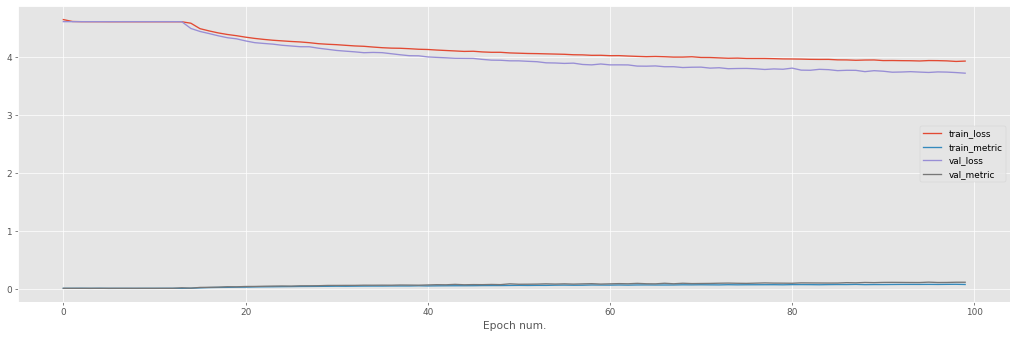

In [27]:
pd.DataFrame(history_lenet).plot()
plt.xlabel('Epoch num.')
plt.show()

### Arquitectura AlexNet

Como hemos visto, la arquitectura AlexNet es una ampliación de la arquitectura LeNet, diseñada para la competición ImageNet que consistía en la clasificación de imágenes de $224 \times 224 \times 3$ en una entre mil clases.

A diferencia que con LeNet, aquí implementaremos una versión un tanto diferente a la de la Figura 2:

1. a última capa no será de 1000, sino de 10, ya que las clases en las que clasificar son 10 dígitos
2. Reduciremos las dimensiones de los filtros de convolución y _pooling_ ya que la imagen de entrada no es lo suficientemente grande para soportarlos (se reducen por debajo de cero píxeles)
3. También eliminaremos los _strides_ por el mismo motivo.

In [28]:
alexnet = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # -> (96, 13, 13)
    torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # -> (256, 6, 6)
    torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding="same"),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=3),  # -> (256, 2, 2)
    torch.nn.Flatten(),  # -> 256 * 2 * 2 = 1024
    torch.nn.Linear(in_features=1024, out_features=4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.75),
    torch.nn.Linear(in_features=4096, out_features=4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.75),
    torch.nn.Linear(in_features=4096, out_features=100),
)

print(alexnet)
total_params = sum(p.numel() for p in alexnet.parameters())
print(f"No. of parameters: {total_params}")

Sequential(
  (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.75, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.75, inplace=False)
  (20): Linear(in_features=4096, out_features=1

Esta arquitectura tiene bastantes más parámetros que las que hemos estado tratando hasta ahora. Además incluye dos capas de _dropout_, las cuales son para regularizar el aprendizaje, y así reducir el _overfitting_ durante el entrenamiento.

Veamos cómo progresa el entrenamiento durante 50 epochs como en los anteriores ejemplos.

In [29]:
history_alexnet = utils.train(
    model=alexnet,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(alexnet.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

Epoch 1/100 (658.99s), Train loss: 4.3419, Train metric: 0.0252, Val loss: 4.1091, Val. metric: 0.0500
Epoch 2/100 (702.58s), Train loss: 3.9781, Train metric: 0.0666, Val loss: 3.7397, Val. metric: 0.1134


KeyboardInterrupt: 

Gráficamente, la evolución queda como sigue:

In [30]:
pd.DataFrame(history_alexnet).plot()
plt.xlabel('Epoch num.')
plt.show()

NameError: name 'history_alexnet' is not defined

Veamos una comparativa entre todos los modelos:

In [31]:
eval_lenet = utils.evaluate(
    model=model_lenet,
    data_loader=test_loader,
    criterion=torch.nn.CrossEntropyLoss(),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)
eval_alexnet = utils.evaluate(
    model=model_alexnet,
    data_loader=test_loader,
    criterion=torch.nn.CrossEntropyLoss(),
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=100),
)

print(f'Results for AlexNet: Loss: {eval_alexnet.get("loss")}, Acc: {eval_alexnet.get("metric")}')
print(f'Results for LeNet:   Loss: {eval_lenet.get("loss")}, Acc: {eval_lenet.get("metric")}')
print(f'Results for CNN 2.0: Loss: {eval_cnn_2.get("loss")}, Acc: {eval_cnn_2.get("metric")}')
print(f'Results for CNN:     Loss: {eval_cnn.get("loss")}, Acc: {eval_cnn.get("metric")}')
print(f'Results for MLP:     Loss: {eval_mlp.get("loss")}, Acc: {eval_mlp.get("metric")}')

NameError: name 'model_lenet' is not defined

Quizá en este ejemplo no es apreciable la potencia de estos modelos respecto a los anteriores, pero lo cierto es que los superan su desempeño en varios órdenes de magnitud en problemas más complejos... y también en tiempo de entrenamiento.

NameError: name 'history_alexnet' is not defined

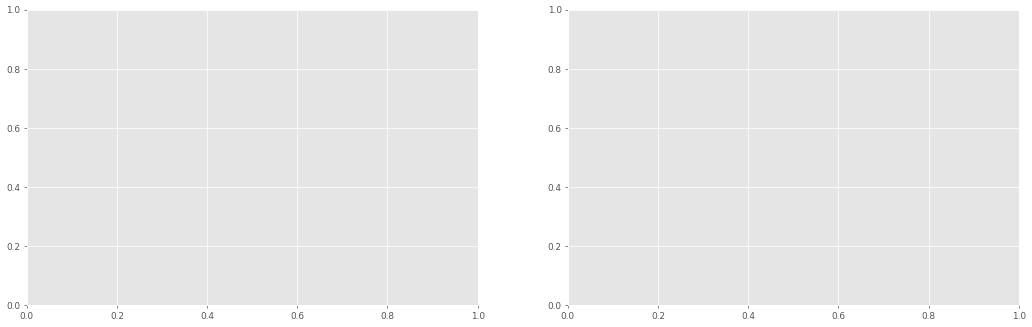

In [32]:
fig, axs = plt.subplots(1, 2)

pd.DataFrame({
    "Alexnet": history_alexnet['val_metric'],
    "LeNet": history_lenet['val_metric'],
    "CNN 2.0": history_cnn_2['val_metric'],
    "CNN": history_cnn['val_metric'],
    "MLP": history_mlp['val_metric'],
}).plot(ax=axs[0])
axs[0].set_xlabel('Epoch num.')
axs[0].set_title('Validation accuracy')

pd.DataFrame({
    "Alexnet": history_alexnet['val_loss'],
    "LeNet": history_lenet['val_loss'],
    "CNN 2.0": history_cnn_2['val_loss'],
    "CNN": history_cnn['val_loss'],
    "MLP": history_mlp['val_loss'],
}).plot(ax=axs[1])
axs[1].set_xlabel('Epoch num.')
axs[1].set_title('Validation loss')

plt.tight_layout()
plt.show()

## Conclusiones

Las redes convolucionales son una arquitectura de red neuronal que aprovecha las características de la entrada para aprender las relaciones existentes. Es equivalente a aproximar un problema de forma más inteligente que la fuerza bruta.

Su principal desventaja es la velocidad de entrenamiento, pero superan con creces la capacidad de resolución de problemas cuando tratamos con elementos como imágenes.

Más adelante veremos otros tipos de redes que solucionan ciertos problemas o que permiten que éstas sean todavía más grandes.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>